In [71]:
import tensorflow as tf

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#tf.enable_eager_execution()
tf.executing_eagerly()
tf.debugging.set_log_device_placement(False) 

# emotions example

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import preprocessing
from preprocessing import clean_html, non_ascii, lower, email_address, punct, remove_underscore

In [28]:
# header=None => leave the first line empty
# sep=';' => separate the emotions to be in an independent column
train_data = pd.read_csv('emotion_dataset/train.txt', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
test_data = pd.read_csv('emotion_dataset/test.txt', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
val_data = pd.read_csv('emotion_dataset/val.txt', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
df = pd.concat([train_data, test_data, val_data], axis=0) #by deafult, concat is by column
df = df.reset_index()

In [25]:
train_data

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [105]:
df.head()

,Input,Sentiment,num_words
0,didnt feel humiliated,4,3
1,can go from feeling so hopeless to so damned ...,4,20
2,m grabbing a minute to post i feel greedy wrong,0,10
3,am ever feeling nostalgic about the fireplace...,3,17
4,am feeling grouchy,0,3


In [54]:
# PREPROCESS THE DATA
def preproc(df, colname):
  df[colname] = df[colname].apply(func=clean_html) 
  df[colname] = df[colname].apply(func=non_ascii)
  df[colname] = df[colname].apply(func=lower)
  df[colname] = df[colname].apply(func=email_address)
  # sentiment anaysis might not need stopword removal ex: not like, not is a stopword
  # df[colname] = df[colname].apply(func=removeStopWords) 
  df[colname] = df[colname].apply(func=punct)
  df[colname] = df[colname].apply(func=remove_underscore)
  return(df)

df_clean = preproc(df, 'Input')
#df_clean.drop('index', axis=1, inplace=True)
df_clean['num_words'] = df_clean['Input'].apply(lambda x: len(x.split()))
df_clean['Sentiment'] = df_clean['Sentiment'].astype('category').cat.codes
encoded_dict = {'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5} 

In [55]:
df_clean

,Input,Sentiment,num_words
0,didnt feel humiliated,4,3
1,can go from feeling so hopeless to so damned ...,4,20
2,m grabbing a minute to post i feel greedy wrong,0,10
3,am ever feeling nostalgic about the fireplace...,3,17
4,am feeling grouchy,0,3
...,...,...,...
19995,m having ssa examination tomorrow in the morni...,4,34
19996,constantly worry about their fight against na...,2,28
19997,feel its important to share this info for tho...,2,14
19998,truly feel that if you are passionate enough ...,2,18


In [57]:

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel 

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42,
                                     stratify=df_clean['Sentiment'])

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

max_len = 70

X_train = tokenizer(
    text=df_train['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False, 
    return_attention_mask=True,
    verbose=True
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [80]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
#from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
#from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [81]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(6, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08, # a very small number to prevent any division by zero
    decay=0.01, # learning rate schedule, learning_rate = learningrate * 1/(1+decay*epoch)
    clipnorm=1.0 # to prevent gradient exploding and gradient vanishing. Clipping is a method where the error derivative is changed or clipped ot a threshold
)

#loss = CategoricalCrossentropy(from_logits=True)
loss = CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy')
#metric = SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['Sentiment']),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(df_test['Sentiment'])),
    epochs=1,
    batch_size=32
) 
""" 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

loss = SparseCategoricalCrossentropy()
metric = SparseCategoricalAccuracy('balanced_accuracy')
#metric = SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    #y = to_categorical(df_train['Sentiment']),
    y = df_train['Sentiment'],
    #validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
    #                    to_categorical(df_test['Sentiment'])),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        df_test['Sentiment']),
    epochs=1,
    batch_size=32
)  """

2022-11-16 12:31:48.676319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - ETA: 0s - loss: 0.6212 - balanced_accuracy: 0.7804

2022-11-16 13:36:55.754970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 4174s 9s/step - loss: 0.6212 - balanced_accuracy: 0.7804 - val_loss: 0.2390 - val_balanced_accuracy: 0.9180


In [102]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                          

In [132]:
model.save_weights("./bert_emotion_weights/model_weight")

In [96]:
model.load_weights("./bert_emotion_weights/model_weight")

In [97]:
history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['Sentiment']),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(df_test['Sentiment'])),
    epochs=2,
    batch_size=32
) 

Epoch 1/2
438/438 [==============================] - 4154s 9s/step - loss: 0.2030 - balanced_accuracy: 0.9237 - val_loss: 0.1874 - val_balanced_accuracy: 0.9258
Epoch 2/2
438/438 [==============================] - 5664s 13s/step - loss: 0.1524 - balanced_accuracy: 0.9367 - val_loss: 0.1765 - val_balanced_accuracy: 0.9277


In [98]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

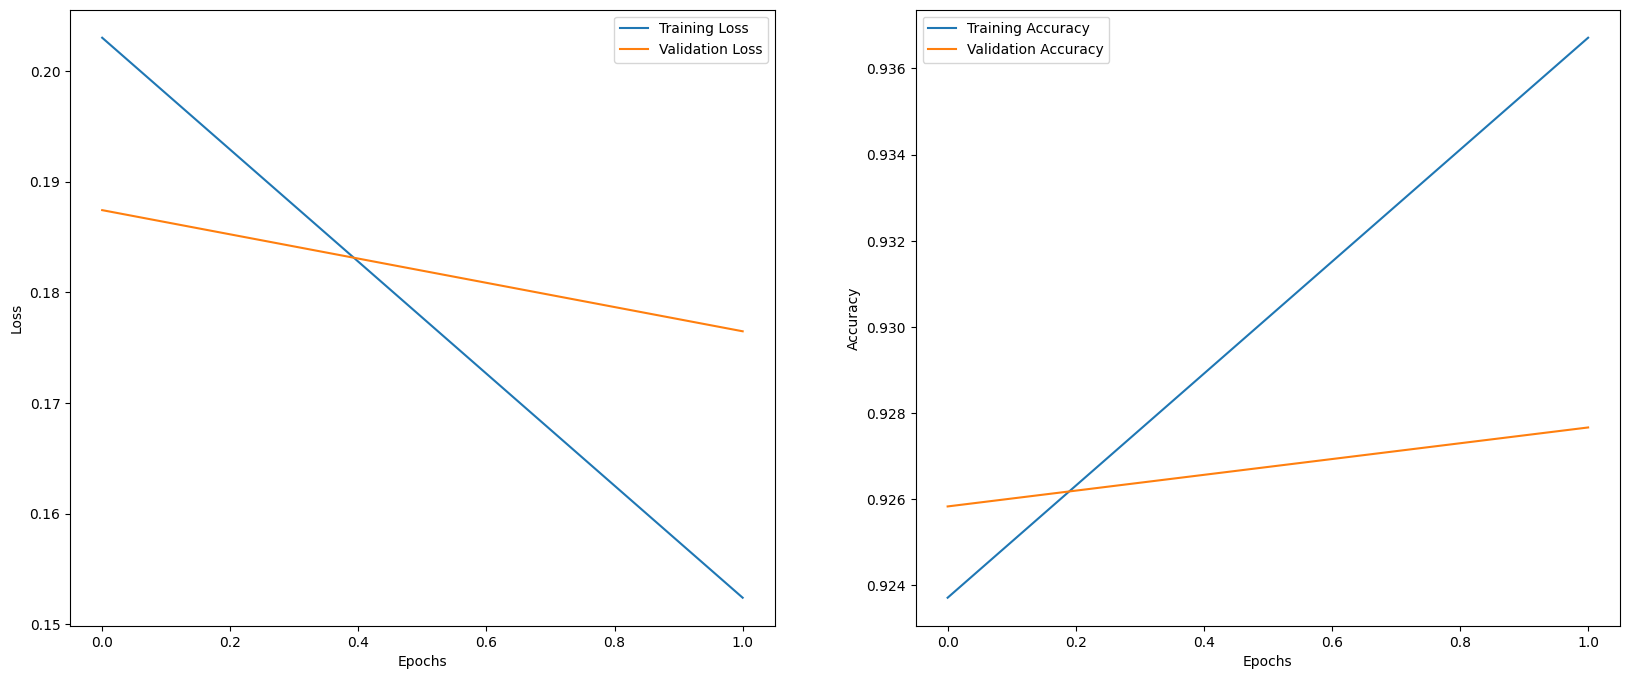

In [99]:
# plot function
def plot_curve(hist):
    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,8))
    ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(epochs, hist.history['balanced_accuracy'], label='Training Accuracy')
    ax[1].plot(epochs, hist.history['val_balanced_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
plot_curve(history)

188/188 [==============================] - 257s 1s/step


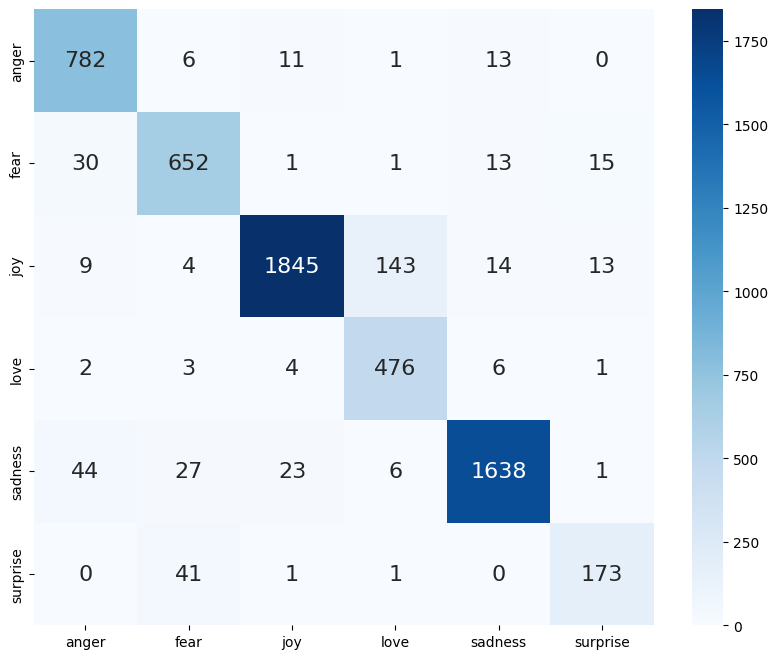

In [100]:
class_names = encoded_dict.keys()
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
# confustion_matrix(y_true, y_prediction)
cnf_matrix = confusion_matrix(df_test['Sentiment'], y_predicted)
df_cnf = pd.DataFrame(cnf_matrix, class_names, class_names)
plt.figure(figsize=(10, 8))
sn.heatmap(df_cnf, annot=True, cmap='Blues', annot_kws={"size": 16},fmt='g')
plt.show()

In [101]:
from sklearn.metrics import classification_report
print(classification_report(df_test['Sentiment'], y_predicted, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.90      0.96      0.93       813
        fear       0.89      0.92      0.90       712
         joy       0.98      0.91      0.94      2028
        love       0.76      0.97      0.85       492
     sadness       0.97      0.94      0.96      1739
    surprise       0.85      0.80      0.83       216

    accuracy                           0.93      6000
   macro avg       0.89      0.92      0.90      6000
weighted avg       0.93      0.93      0.93      6000



In [130]:
# test_single
text = "Life is too short to be serious all the time. So if you can’t laugh at yourself, call me I will laugh at you"
df_single = pd.DataFrame({"Input": [text]})
df_single_clean = preproc(df_single, 'Input')
#df_clean.drop('index', axis=1, inplace=True)
df_single_clean['num_words'] = df_clean['Input'].apply(lambda x: len(x.split()))
#df_single_clean['Sentiment'] = df_clean['Sentiment'].astype('category').cat.codes
df_single = tokenizer(
    text=df_single_clean['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding="max_length", # since test single here, to make is padding to 70, cange from True to "max_legth"
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
predicted_single = model.predict({'input_ids': df_single['input_ids'], 'attention_mask': df_single['attention_mask']})
y_predicted_single = np.argmax(predicted_single, axis=1)
y_predicted_single = list(encoded_dict.keys())[y_predicted_single[0]]
y_predicted_single

1/1 [==============================] - 9s 9s/step


'joy'

In [133]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

loss = SparseCategoricalCrossentropy()
metric = SparseCategoricalAccuracy('balanced_accuracy')
#metric = SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    #y = to_categorical(df_train['Sentiment']),
    y = df_train['Sentiment'],
    #validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
    #                    to_categorical(df_test['Sentiment'])),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        df_test['Sentiment']),
    epochs=1,
    batch_size=32
) 

2022-11-16 19:28:36.699940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
